# Studies with EFT nanoGEN samples

We will use two flavors of samples:
- SMEFTatNLO with SM settings: `TTWJetsToLNuEWK_5f_NLO`
- SMEFTatNLO with NP settings: `TTWJetsToLNuEWK_5f_EFT_myNLO`
    - cpt = 1, cpQ3 = 1, cpQM = 1, ctZ = 1, ctW = 1.
    However, there is some funny MG behaviour, so we can't be certain that these settings have actually worked.
    The reported x-sec by MG is `8.987e-02 +- 8.6e-05 pb`


In [2]:
import uproot
import numpy as np
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

import glob

In [3]:
f=uproot.open('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANOGEN_v1/output_10.root')
tree = f['Events']
df = LazyDataFrame(tree, flatten=True)

In [4]:
tree.show()

run                        (no streamer)              asdtype('>u4')
luminosityBlock            (no streamer)              asdtype('>u4')
event                      (no streamer)              asdtype('>u8')
nGenJetAK8                 (no streamer)              asdtype('>u4')
GenJetAK8_eta              (no streamer)              asjagged(asdtype('>f4'))
GenJetAK8_mass             (no streamer)              asjagged(asdtype('>f4'))
GenJetAK8_phi              (no streamer)              asjagged(asdtype('>f4'))
GenJetAK8_pt               (no streamer)              asjagged(asdtype('>f4'))
nGenJet                    (no streamer)              asdtype('>u4')
GenJet_eta                 (no streamer)              asjagged(asdtype('>f4'))
GenJet_mass                (no streamer)              asjagged(asdtype('>f4'))
GenJet_phi                 (no streamer)              asjagged(asdtype('>f4'))
GenJet_pt                  (no streamer)              asjagged(asdtype('>f4'))
nGenPart               

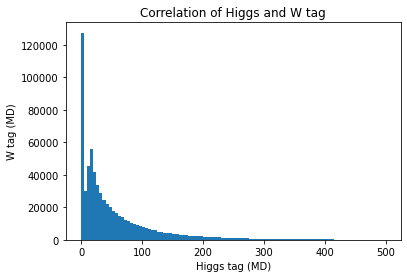

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

figure=plt.figure(1)
plt.hist(df["GenPart_pt"], bins=100, range=[0, 500], )
plt.xlabel('Higgs tag (MD)')
plt.ylabel('W tag (MD)')
plt.title('Correlation of Higgs and W tag')

plt.show()

In [30]:
GenPart = JaggedCandidateArray.candidatesfromcounts(
    df['nGenPart'],
    pt=df['GenPart_pt'],
    eta=df['GenPart_eta'],
    phi=df['GenPart_phi'],
    mass=df['GenPart_mass'],
    pdgId=df['GenPart_pdgId'],
    status=df['GenPart_status'],
    genPartIdxMother=df['GenPart_genPartIdxMother'],
    statusFlags=df['GenPart_statusFlags']
)

GenJet = JaggedCandidateArray.candidatesfromcounts(
    df['nGenJet'],
    pt=df['GenJet_pt'],
    eta=df['GenJet_eta'],
    phi=df['GenJet_phi'],
    mass=df['GenJet_mass'],
    hadronFlavour=df['GenJet_hadronFlavour'],
    partonFlavour=df['GenJet_partonFlavour'],
)


# we always have three generated Ws with statusFlag 13
W = GenPart[((abs(GenPart.pdgId)==24) & ((GenPart.statusFlags & (1 << 13)) > 0))]
# the incoming W bosons either from top or q/g
incomingW = GenPart[((abs(GenPart.pdgId)==24) & (GenPart.status==22))]
# last copy of the tops
top = GenPart[((abs(GenPart.pdgId)==6) & ((GenPart.statusFlags & (1 << 13)) > 0))]
# give the spectators a shot. this is how I've previously done that
hardScatter = GenPart[((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1))]
spectator = GenPart[(((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1)) & (abs(GenPart.pdgId)<6))]

# all Ws
allW = GenPart[(abs(GenPart.pdgId)==24)]

## Jets
centralLight = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour<5))]
forward = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)>2.0) & (abs(GenJet.eta)<4.7))]
bjet = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour==5))]


In [7]:
# status bit fromHardProcess=8, isHardProcess=7
GenPart[((GenPart.statusFlags & (1 << 7)) > 0) & ((GenPart.statusFlags & (1 << 13)) > 0)].genPartIdxMother

<JaggedArray [[-1 -1] [-1 -1] [-1 -1 20 20] ... [-1 -1 22 22] [-1 -1 11 16 16] [-1 -1 10 10]] at 0x7f4bdd1cc7b8>

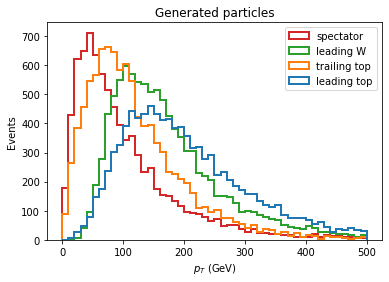

In [28]:
figure=plt.figure(1)
plt.hist([top.pt.max(), top.pt.min(), W.pt.max(), spectator.pt.flatten()], label=['leading top', 'trailing top', 'leading W', 'spectator'], bins=50, range=[0, 500], histtype='step', linewidth=2)
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel('Events')
plt.title('Generated particles')
plt.legend()
plt.show()

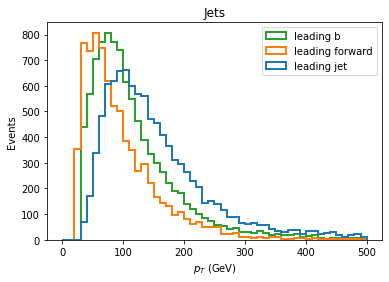

In [31]:
figure=plt.figure(1)
plt.hist([centralLight.pt.max(), forward.pt.max(), bjet.pt.max()], label=['leading jet', 'leading forward', 'leading b'], bins=50, range=[0, 500], histtype='step', linewidth=2)
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel('Events')
plt.title('Jets')
plt.legend()
plt.show()

In [38]:
GenJet.p4.p

<JaggedArray [[140.9065 196.40662 243.46269 ... 25.954258 16.966099 25.491096] [473.9648 157.6422 227.15935 ... 108.45102 156.12288 11.203249] [143.7617 87.47755 60.377552 ... 90.949295 907.4374 232.94833] ... [2563.1462 277.37732 119.23776 ... 27.755789 26.66788 20.075773] [437.618 316.0933 546.36884 ... 55.265743 33.919662 75.87001] [259.90637 349.47858 378.4739 ... 12.488545 33.46456 15.670584]] at 0x7f4bccdf44e0>

In [40]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
import pandas as pd
import uproot_methods
import awkward

from memory_profiler import profile

from Tools.helpers import loadConfig, getCutFlowTable, mergeArray

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [168]:
class exampleProcessor(processor.ProcessorABC):
    """Dummy processor used to demonstrate the processor principle"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 5000)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        deltaEta_axis            = hist.Bin("deltaEta",       r"$\eta$", 100, 0, 10)
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis            = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "leading_top_pt" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_top_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "leading_bjet_pt" :   hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_bjet_pt" :  hist.Hist("Counts", dataset_axis, pt_axis),
            "leading_W_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "trailing_W_pt" :    hist.Hist("Counts", dataset_axis, pt_axis),
            "spectator_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "fw_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "leadingForward_p" : hist.Hist("Counts", dataset_axis, p_axis),
            "m_jj" :             hist.Hist("Counts", dataset_axis, mass_axis),
            "deltaEta_jj" :             hist.Hist("Counts", dataset_axis, deltaEta_axis),
            'totalEvents':      processor.defaultdict_accumulator(int),

        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        # GenPart
        GenPart = JaggedCandidateArray.candidatesfromcounts(
            df['nGenPart'],
            pt=df['GenPart_pt'].content,
            eta=df['GenPart_eta'].content,
            phi=df['GenPart_phi'].content,
            mass=df['GenPart_mass'].content,
            pdgId=df['GenPart_pdgId'].content,
            status=df['GenPart_status'].content,
            genPartIdxMother=df['GenPart_genPartIdxMother'].content,
            statusFlags=df['GenPart_statusFlags'].content
        )
        
        # we always have three generated Ws with statusFlag 13
        W = GenPart[((abs(GenPart.pdgId)==24) & ((GenPart.statusFlags & (1 << 13)) > 0))]
        # the incoming W bosons either from top or q/g
        incomingW = GenPart[((abs(GenPart.pdgId)==24) & (GenPart.status==22))]
        # last copy of the tops
        top = GenPart[((abs(GenPart.pdgId)==6) & ((GenPart.statusFlags & (1 << 13)) > 0))]
        # give the spectators a shot. this is how I've previously done that
        hardScatter = GenPart[((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1))]
        spectator = GenPart[(((GenPart.genPartIdxMother==0) | (GenPart.genPartIdxMother==1)) & (abs(GenPart.pdgId)<6))]
        
        ## Jets
        GenJet = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt = df['GenJet_pt'].content,
            eta = df['GenJet_eta'].content,
            phi = df['GenJet_phi'].content,
            mass = df['GenJet_mass'].content,
            hadronFlavour = df['GenJet_hadronFlavour'].content,
            partonFlavour = df['GenJet_partonFlavour'].content,
        )
        ## Jets
        light        = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)<4.7) & (GenJet.hadronFlavour<5))]
        centralLight = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour<5))]
        forward      = GenJet[((GenJet.pt>25) & (abs(GenJet.eta)>2.0) & (abs(GenJet.eta)<4.7))]
        bjet         = GenJet[((GenJet.pt>30) & (abs(GenJet.eta)<2.4) & (GenJet.hadronFlavour==5))]
        
        fw           = light[abs(light.eta).argmax()] # the most forward light jet
        leadingForward = forward[forward.p4.p.argmax()] # forward jet with highest momentum

        ## other variables
        ht = GenJet.pt.sum()
        
        ## Event classifieres
        # We want to get the deltaEta between the most forward jet fw and the jet giving the largest invariant mass with fw, fw2
        jj = fw.cross(light)
        deltaEta = abs(fw.eta - jj[jj.mass.argmax()].i1.eta)
        deltaR = abs(fw.eta - jj[jj.mass.argmax()].i1.eta)
        deltaEtaJJMin = ((deltaEta>2).any())
        
        #output['totalEvents']['all'] += len(df['genWeight'])
        
        ### And fill the histograms
        # just the number of electrons and muons
        output['leading_top_pt'].fill(dataset=dataset, pt=top.pt.max().flatten(), weight=df['genWeight'][top.counts>0])
        output['trailing_top_pt'].fill(dataset=dataset, pt=top.pt.min().flatten(), weight=df['genWeight'][top.counts>0])
        output['leading_bjet_pt'].fill(dataset=dataset, pt=bjet[bjet.pt.argmax()].pt.flatten(), weight=df['genWeight'][bjet.counts>0])
        output['trailing_bjet_pt'].fill(dataset=dataset, pt=bjet[bjet.pt.argmin()].pt.flatten(), weight=df['genWeight'][bjet.counts>0])
        output['leading_W_pt'].fill(dataset=dataset, pt=W.pt.max().flatten(), weight=df['genWeight'][W.counts>0])
        output['trailing_W_pt'].fill(dataset=dataset, pt=W.pt.min().flatten(), weight=df['genWeight'][W.counts>0])
        output['spectator_pt'].fill(dataset=dataset, pt=spectator.pt.flatten(), weight=df['genWeight'][spectator.counts>0])
        output['fw_pt'].fill(dataset=dataset, pt=fw.pt.flatten(), weight=df['genWeight'][fw.counts>0])
        output['leadingForward_p'].fill(dataset=dataset, p=leadingForward.p4.p.flatten(), weight=df['genWeight'][leadingForward.counts>0])
        output['m_jj'].fill(dataset=dataset, mass=jj[jj.mass.argmax()].mass.flatten(), weight=df['genWeight'][jj.counts>0])
        output['deltaEta_jj'].fill(dataset=dataset, deltaEta=deltaEta.flatten(), weight=df['genWeight'][jj.counts>0])
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [158]:
fileset = {'SM' : glob.glob('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANOGEN_v1/*.root'),
           'EFT': glob.glob('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_EFT_myNLO_RunIIAutumn18_NANOGEN_v1/*.root')}

In [169]:
output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=exampleProcessor(),
                                      executor=processor.futures_executor,
                                      executor_args={'workers': 4, 'function_args': {'flatten': False}},
                                      chunksize=250000,
                                     )

In [170]:
bins = {\
        'leading_W_pt':         {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (W) \ (GeV)$', 25, 0, 1000)},
        'trailing_W_pt':         {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (W) \ (GeV)$', 25, 0, 250)},
        'leading_top_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (top) \ (GeV)$', 25, 0, 1000)},
        'trailing_top_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (top) \ (GeV)$', 25, 0, 500)},
        'leading_bjet_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (top) \ (GeV)$', 25, 0, 500)},
        'trailing_bjet_pt':       {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (top) \ (GeV)$', 25, 0, 250)},
        'spectator_pt': {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (spectator) \ (GeV)$', 25, 0, 500)},
        'fw_pt':        {'axis': 'pt',            'overflow':'over',  'bins': hist.Bin('pt', r'$p_T (most forward jet) \ (GeV)$', 25, 0, 250)},
        'leadingForward_p': {'axis': 'p',        'overflow':'over',  'bins': hist.Bin('p', r'$p (hardest forward jet) \ (GeV)$', 25, 0, 5000)},
        'm_jj': {'axis': 'mass',        'overflow':'over',  'bins': hist.Bin('mass', r'$m (jj) max \ (GeV)$', 25, 0, 2000)},
        'deltaEta_jj': {'axis': 'deltaEta',        'overflow':'over',  'bins': hist.Bin('deltaEta', r'$\Delta\eta (jj) $', 25, 0, 10)},
       }

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


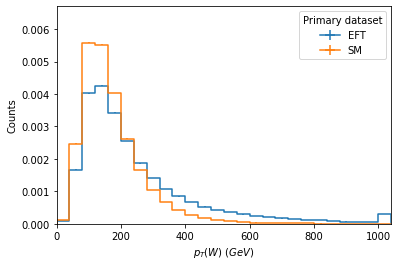

In [130]:
name = 'leading_W_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


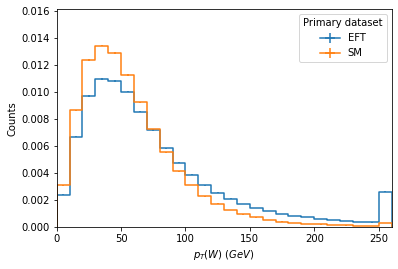

In [131]:
name = 'trailing_W_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


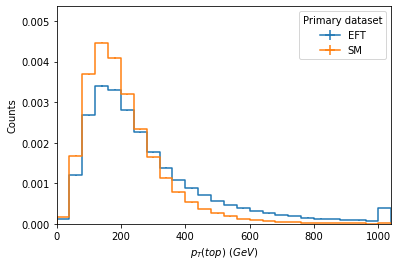

In [132]:
name = 'leading_top_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


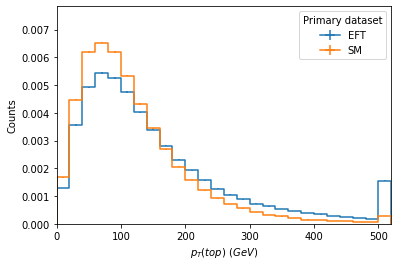

In [133]:
name = 'trailing_top_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


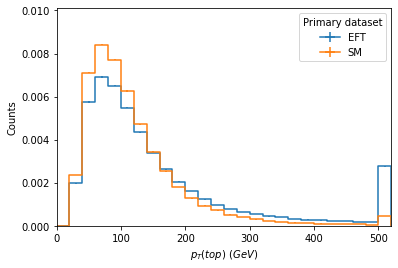

In [134]:
name = 'leading_bjet_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


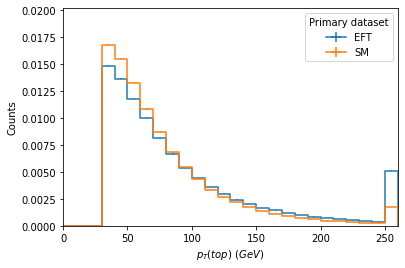

In [135]:
name = 'trailing_bjet_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


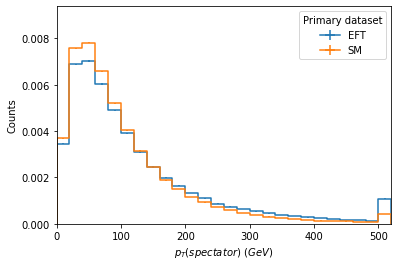

In [136]:
name = 'spectator_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


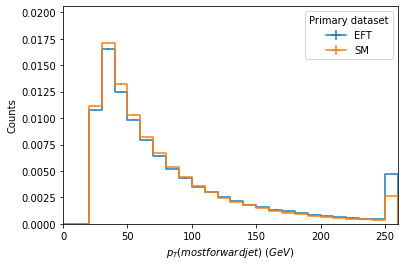

In [137]:
name = 'fw_pt'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


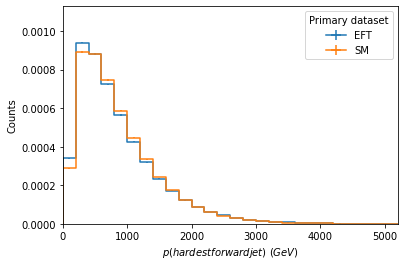

In [138]:
name = 'leadingForward_p'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


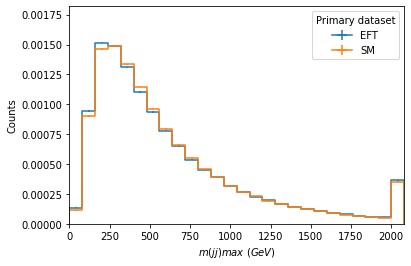

In [153]:
name = 'm_jj'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


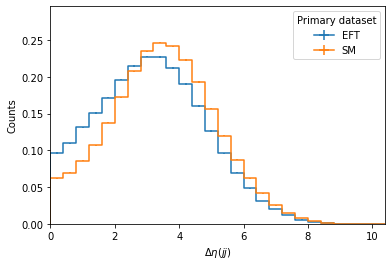

In [171]:
name = 'deltaEta_jj'
histogram = output[name]
histogram = histogram.rebin(bins[name]['axis'], bins[name]['bins'])
ax = hist.plot1d(histogram,overlay="dataset", stack=False, density=True, overflow='over')

Lessons we can learn from here:
- If the top get's harder, b-jet pt could be an interesting variable
- Highest lepton pt! Could make 3 lepton channel interesting for EFT
- Forward jets / spectator are not really affected, and the effect washes out quickly when one has to look at jets instead of the GenPart
- M(jj) is cool for isolating top-W scattering, but it's unaffected by NP